In [ ]:
import sys

sys.path.insert(0, "..")

In [14]:
from src.utils import setup_dirs
import os
from pathlib import Path
import matplotlib.pyplot as plt

from monai.utils import set_determinism
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import DataLoader

from src.datasets.acdc_dataset import ACDCDataset
from src.transforms import get_transforms

set_determinism(seed=0)

from torch.utils.data import random_split

train_transforms = get_transforms("end_diastole", "end_diastole_label")
root_dir = Path(os.getcwd()).parent

data_dir, log_dir, out_dir = setup_dirs(root_dir)
data_dir = data_dir / "ACDC" / "database"
train_data = ACDCDataset(data_dir=data_dir, train=True, transform=train_transforms)

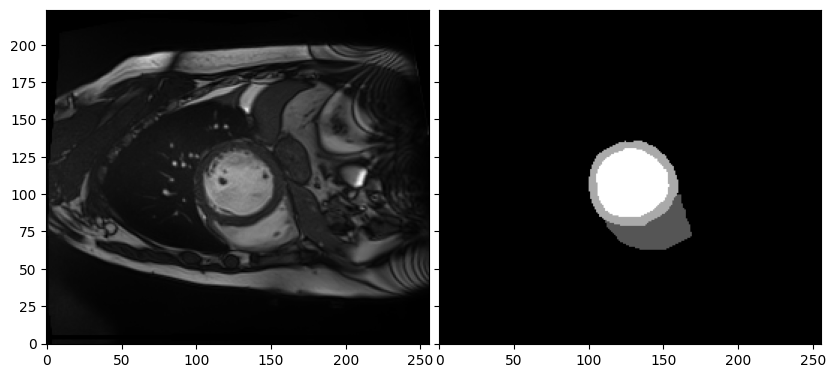

In [15]:
check_dataloader = DataLoader(train_data, batch_size=1, shuffle=False)
check_data = next(iter(check_dataloader))
image, label = check_data["end_diastole"][0][0], check_data["end_diastole_label"][0][0]

# slices = image.shape[2]
slices = 1
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(slices, 2), axes_pad=0.1)

images = []
for i in range(slices):
    images.append(image[:, :, i])
    images.append(label[:, :, i])

for ax, image in zip(grid, images):
    ax.imshow(image, cmap="gray", origin="lower")

plt.show()

In [16]:
train_data = ACDCDataset(data_dir=data_dir, train=True, transform=train_transforms)

total_training_number = len(train_data)
validation_split = 0.8
train_size = int(validation_split * total_training_number)
test_size = total_training_number - train_size

# TODO: cache dataset
# train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=1)
# val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=1)

train_ds, val_ds = random_split(train_data, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)

In [17]:
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
unet_layers = 3
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    norm=Norm.INSTANCE,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [18]:
from monai.data import decollate_batch
from torch.utils.tensorboard import SummaryWriter
from monai.transforms import AsDiscrete, Compose

max_epochs = 100
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(to_onehot=4, argmax=True)])
post_label = Compose([AsDiscrete(to_onehot=4)])

writer = SummaryWriter(log_dir=str(log_dir))

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["end_diastole"].to(device),
            batch_data["end_diastole_label"].to(device),
        )

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_loader.dataset) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}"
        )

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    writer.add_scalar("Epoch loss", epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["end_diastole"].to(device),
                    val_data["end_diastole_label"].to(device),
                )
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            writer.add_scalar("Validation dice score", metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(
                    model.state_dict(),
                    os.path.join(out_dir, "best_metric_model.pth"),
                )
                print(f"New best metric found: {best_metric}")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

writer.close()

----------
epoch 1/100


/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and

1/80, train_loss: 0.8834
2/80, train_loss: 0.8811
3/80, train_loss: 0.8740
4/80, train_loss: 0.8808
5/80, train_loss: 0.8823
6/80, train_loss: 0.8758
7/80, train_loss: 0.8846
8/80, train_loss: 0.8746
9/80, train_loss: 0.8692
10/80, train_loss: 0.8779
11/80, train_loss: 0.8659
12/80, train_loss: 0.8676
13/80, train_loss: 0.8791
14/80, train_loss: 0.8725
15/80, train_loss: 0.8626
16/80, train_loss: 0.8758
17/80, train_loss: 0.8698
18/80, train_loss: 0.8769
19/80, train_loss: 0.8675
20/80, train_loss: 0.8712
21/80, train_loss: 0.8667
22/80, train_loss: 0.8631
23/80, train_loss: 0.8682
24/80, train_loss: 0.8645
25/80, train_loss: 0.8678
26/80, train_loss: 0.8731
27/80, train_loss: 0.8652
28/80, train_loss: 0.8711
29/80, train_loss: 0.8649
30/80, train_loss: 0.8660
31/80, train_loss: 0.8674
32/80, train_loss: 0.8563
33/80, train_loss: 0.8698
34/80, train_loss: 0.8674
35/80, train_loss: 0.8565
36/80, train_loss: 0.8557
37/80, train_loss: 0.8664
38/80, train_loss: 0.8623
39/80, train_loss: 0.

KeyboardInterrupt: 